# Generating Names with Bigrams
<!-- Basic Bigram Generator -->

## Table of Contents
1) [Project Overview](#overview)
2) [Preparing the Data](#data)
3) [Building the Bigram Model](#model)
4) [Training the Model](#training)
5) [Generating Names](#generate)
6) [Next Steps](#next)

<a id="overview"></a>
## Project Overview
In this project, we will build a character-level bigram language model from scratch and use it to generate names. The model will take a letter as input and output the probability of each possible next letter. It will then use these probabilities to pick the next letter in a name, then take that next letter as input to continue generating the name one letter at a time.

<!-- then feed that new letter back into the model to continue generating the name, one letter at a time. -->


This model will use only a single layer of neurons, making it easy to see exactly how the math works under the hood.

This notebook is written as both a learning exercise and a teaching tool. Every step is explained in detail, including the math behind data preparation, model predictions, loss calculation, and gradient updates. The code is intentionally kept minimal, without relying on high-level ML frameworks, so the core ideas are completely transparent.

<!-- After finishing the notebook, you should understand each step  -->

<!-- This notebook is both a learning exercise and a teaching tool. Each step explains what's happening, why it's done, and how it connects to later concepts in machine learning. -->

<!-- The goal is to understand every step of the process, from preparing text data, to implementing the model, to training it using gradient-based optimization, to sampling from the trained model. -->

<!-- All components are implemented manually, without using high-level deep learning shortcuts, so the notebook serves as both: -->

<!-- The code is intentionally kept minimal, without relying on high-level ML frameworks, so the core ideas are completely transparent. -->


<!-- 
Key features of this notebook:
- Data preparation from raw text to numeric form.
- Manual implementation of one-hot encoding, softmax, and loss functions.
- Training loop with gradient calculation and parameter updates.
- Name generation using multinomial sampling from the trained model.
 -->


<!-- The goal of this notebook is to build a simple language model that can generate names resembling the real ones from its training data. To accomplish this goal, we'll build a simple neural network and train it on pairs of consecutive letters (bigrams) found in names. The model will be able to take a letter as input and output the probability of each possible next letter. We can then use these probabilities to pick the next letter in a name, then feed that new letter back into the model to continue generating the name, one letter at a time. -->


<!-- In this notebook, we build a simple language model that can generate names resembling the real ones from its training data.  -->

<!-- The model will be made from scratch and will use only a single layer of neurons.  -->

<!-- This notebook is both a learning exercise and a teaching tool. Each step explains what's happening, why it's done, and how it connects to later concepts in machine learning. -->

<!-- To make each step and simple and clear as possible, the model will be made from  -->

<!-- This will be done from scratch, using only a single layer of neurons. The model should be able to take a letter as input and output the probability of each possible letter -->



<!-- This notebook builds a character-level bigram language model from scratch using only a single layer of neurons. It's both a learning exercise and a teaching tool. Each step explains what's happening, why it's done, and how it connects to later concepts in machine learning. -->


<!-- The goal of this project is to train a bigram model to generate names. -->

<!-- 

By the end, we'll have trained a bigram model to generate names.

predict the next character in a name, and use 




<!-- This notebook builds a simple language model that generates names resembling real ones from its training data. This is done with a  -->

<!-- This notebook builds a simple neural network from scratch. It's both a learning exercise and a teaching tool. Each step explains what's happening, why it's done, and how it connects to later concepts in machine learning. -->




<!-- The goal of this project is to create a simple language model that can generate names resembling real ones from its training data. -->

<!-- I am making this project to review what I've been learning, but also to format it all  -->

<!-- We'll use a neural network trained on character-level bigrams -- that is, pairs of consecutive letters. When the model is given a letter as input, it should predict the probability of each possible next letter. We can then use these probabilities to pick the next letter in a name, then feed that new letter back into the model to continue generating the name, one letter at a time. -->

<a id="data"></a>
## Preparing the Data
We'll start by reading in a list of names we will use to train our model.

In [269]:
# Create a list of each name in names.txt
names = open("names.txt", "r").read().splitlines()
print(f"Displaying the first three names: {names[:3]}")

Displaying the first three names: ['emma', 'olivia', 'ava']


Now that we have a list of names, we need to prepare these names in a way that our model can use for training. However, we can't train on *all* the names here. If we do, then even if our model becomes amazing at generating these names, we'd have no way of knowing if it can create any realistic sounding names that weren't directly taken from the training data.


We want a model that doesn't just memorize the data, but instead learns patterns within the data so that it can generate new names which still sound natural. 

### Splitting Data into Train, Validation, and Test Sets

To make sure the model doesn't just memorize the data, we need to split the data into three sets.
1) Training Set: Used to teach the model the patterns in the data.
2) Validation/Dev Set: Used during development to evaluate how well the model performs on data it wasn't trained with. If the performance is poor, this alerts us to adjust some of the model's settings before training it once again with the training set. 
3) Test Set: Used only once, after the model is fully trained, to see how well the finished model performs on all new, never-before-seen data.

Let's split the data into these three sets now. We want each set to have a similar letter distribution, so we'll shuffle the names first in case the data was ordered any way that would bias the training.

In [270]:
import random    # Adds shuffling capabilities.

random.seed(42)
random.shuffle(names)

print(f"First three names after shuffling: {names[:3]}")

First three names after shuffling: ['yuheng', 'diondre', 'xavien']


Most of the data should be used for training the model, so we'll keep 80% for the training set, 10% for the dev set, and the remaining 10% for the test set.

In [271]:
# The training set will end at the 80% mark of all names.
train_end_index = int(0.8 * len(names))
train_set = names[:train_end_index]

# Dev set will contain the next 10% of names, so it will end at 80 + 10 = 90% of data. 
dev_end_index = int(0.9 * len(names))
dev_set = names[train_end_index:dev_end_index]

# Remaining data will be used for test set.
test_end_index = len(names)
test_set = names[dev_end_index:]

print(f"Training set contains {len(train_set)} names.")
print(f"Dev set contains {len(dev_set)} names.")
print(f"Test set contains {len(test_set)} names.")

Training set contains 25626 names.
Dev set contains 3203 names.
Test set contains 3204 names.


### From Names to Bigrams

We want to teach our model the common letter patterns found in names. For this, we'll break each name into character-level bigrams. We also want it to learn how each name starts and ends, so let's indicate the start and end of a name with a ".". Below shows an example of the bigrams in the name Emma.

In [272]:
# Break "emma" into bigrams, including "." for start and end.
print(f"Bigrams for emma: {list(zip('.emma', 'emma.'))}")

Bigrams for emma: [('.', 'e'), ('e', 'm'), ('m', 'm'), ('m', 'a'), ('a', '.')]


To use these bigrams in our neural network, we'll organize them into two tensors: X (inputs) and y (labels).
- X will contain the first letter of each bigram. These are the inputs we'll feed into the model.
- y will contain the second letter of each bigram, i.e., the letter that follows each input letter in X. These are the labels (targets) the model should learn to predict.


Storing them as tensors instead of lists allows us to use them directly with our model. Let's import PyTorch for its tensors.

In [273]:
import torch    # Tensors and backpropagation.

Unfortunately, tensors can't contain character elements, so we can't store the bigrams directly. Instead, let's assign each letter to an integer value so we can store those instead.

In [274]:
import string

# For each letter + ".", add them to dict with an integer value.
stoi = {char:int_val for (int_val, char) in enumerate("." + string.ascii_lowercase)}
print(stoi)

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


Of course, we'll also need a way to find out which letters those numbers represent later, so we'll make another dictionary that can turn them back.

In [275]:
itos = {num: letter for letter, num in stoi.items()}
print(itos)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


Now we are ready to split all the names into bigrams. We'll have to do it seperately for each of the sets (train, dev, and test), so we'll put the bigram code into a function to keep the code clean.

In [276]:
def get_bigrams(names):
    X = [] # First letters in bigrams
    y = [] # X's bigram pairs.

    for name in names:
        for char1, char2 in zip("." + name, name + "."):
            # Convert chars to ints so we can later add to tensors.
            X.append(stoi[char1])
            y.append(stoi[char2])

    # Convert lists to tensors.
    X = torch.tensor(X)
    y = torch.tensor(y)
    return X, y


train_X, train_y = get_bigrams(train_set)
dev_X, dev_y = get_bigrams(dev_set)
test_X, test_y = get_bigrams(test_set)


print(f"Our training set now has {len(train_X)} examples.")
print(f"The first 10 values in train_X are {train_X[:10]}.")
print(f"The first 10 values in train_y are {train_y[:10]}.")

Our training set now has 182625 examples.
The first 10 values in train_X are tensor([ 0, 25, 21,  8,  5, 14,  7,  0,  4,  9]).
The first 10 values in train_y are tensor([25, 21,  8,  5, 14,  7,  0,  4,  9, 15]).


Now the data is almost ready to be used in a neural network, but there is still one issue. 

When you use a neural network, you feed it input examples and the network does math with those inputs to arrive at an output. Specifically, it multiplies each input by float values called "weights". Right now, our inputs are just numbers from 0 to 26. It wouldn't be very helpful to do math with these inputs, since we want each letter to be treated equally. There is no reason that "z" should be mathematically larger than "a", for example.

To make sure each input gets treated equally, we can change our inputs with a method called **one-hot encoding**. 

### One-Hot Encoding

With one-hot encoding, each letter gets represented by an array of length 27 (one for each possible letter including "."). This array contains all 0s apart from a single 1 at the index signifying the chosen letter. To show this more visually, let's explore the one-hot encoded version of the letter "c".

In [277]:
# Get number used to represent c. This will be the index of the 1 after one-hot encoding.
c_index = stoi["c"]

# Create the one-hot encoded representation of the letter "c".
c_enc = torch.zeros(27)
c_enc[c_index] = 1

print(f"c's index is {c_index}, so its one-hot encoding looks like {c_enc}")

c's index is 3, so its one-hot encoding looks like tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])


Let's apply this encoding to all the letters in our input data sets. Rather than encoding them all manually like above, we'll use PyTorch's one_hot() function. 

In [278]:
import torch.nn.functional as F

# One-hot encode Xs to turn each letter into an array of length 27 (one index for each possible letter including ".".)
train_X_enc = F.one_hot(train_X, num_classes = 27)
dev_X_enc = F.one_hot(dev_X, num_classes = 27)
test_X_enc = F.one_hot(test_X, num_classes = 27)


# View encodings for first 5 letters of the training set.
train_X_enc[:5]

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0]])

You may notice that the resulting tensors contain integers. To later multiply them by the float weights in our neural network, we'll need to convert those values into floats.

<!-- Neural networks contain floats, so we need to convert these to floats so that the network can interact with them. -->


In [279]:
# We want the neural net to produce floats, so the inputs must be floats as well.
train_X_enc = train_X_enc.float()
dev_X_enc = dev_X_enc.float()
test_X_enc = test_X_enc.float()

# The first letter in the training set is now encoded with floats.
train_X_enc[0]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

Now that we've finished preparing the data, we're ready to build our model.

<a id="model"></a>
## Building the Bigram Model

For this project, we'll use a very simple neural network with only a single layer of neurons. 

Before we jump into building this layer, it's important to understand how a single neuron works.

Since each input letter now has a length of 27 (due to the encoding), this one neuron will need 27 weights so each element in the inputs can be multiplied by a unique weight. The weights will start off as random numbers from a normal distribution. (After training the model, these numbers should become more meaningful.)

In [280]:
# A single neuron with one weight for each element in our input.
W = torch.randn(27, 1)
print("Here is a single neuron with a 27 weights:")
print(W)

Here is a single neuron with a 27 weights:
tensor([[-1.0820],
        [ 0.1704],
        [-0.2749],
        [-0.0541],
        [ 0.1841],
        [-1.5424],
        [-1.7836],
        [-1.7870],
        [-1.2490],
        [-0.1310],
        [ 0.3556],
        [-1.5266],
        [-1.1401],
        [ 0.7954],
        [ 0.5753],
        [ 0.4907],
        [-0.0549],
        [ 1.4208],
        [ 1.0351],
        [-1.4965],
        [-1.4441],
        [-0.1644],
        [ 0.5945],
        [ 0.6550],
        [-2.1112],
        [-0.3934],
        [-0.5652]])


Now we can use this neuron by multiplying our inputs with it.


When the input is a one-hot encoded vector, the dot product multiplies all weights by 0 except for the one weight at the position where the input has a 1. Each of the resulting multiplications are then added together, but since most of the values are 0, they end up ignored by the result. Thus, it is as if each one-hot encoded input simply selects the corresponding weight from the neuron and ignores the rest.

In [281]:
print("c_enc has a 1 at index 3, so the dot product should select the neuron's weight at index 3.")
c_enc @ W

c_enc has a 1 at index 3, so the dot product should select the neuron's weight at index 3.


tensor([-0.0541])

As described earlier, we want our model to take a letter as input and output the probability of each possible next letter. Since there are 27 possible next letters, the model should produce a vector of 27 probabilities, one for each letter.

We've seen that a single neuron produces one output. Thus, to produce 27 outputs, we'll need a layer of 27 neurons. Since each neuron is a column of weights, 27 neurons would be represented by a tensor with 27 columns (resulting in a 27x27 matrix).

We'll also need to set `requires_grad=True` when creating the tensor. This is necessary for later, as it will help us adjust the weights during training. We'll go into more detail about gradients once we get to the section on training the model.

<!-- and how they are used to train the model in the next section. -->


<!-- We'll explore what that means further once we start training

Apart from having the right amount of neurons, we also need a way to update the weights during training. For that, we'll need to set `requires_grad=True` when we create the tensor. We'll explore what these means further once we get to training the model. -->


<!-- we'll also need a way to eventually adjust the weights to train the model. We do this by setting `requires_grad=True` when we create the tensor. This allows us to update the weights during training. We'll explore what these means further once we get to training the model. -->
<!-- 
Once we begin training

, which tells PyTorch that this tensor . 

This tells the model to keep track of all the operations within it, 

This won't do anything noticeable yet, but it will be necessary later when it comes to training the model. We'll explore what  -->


<!-- We'll also need a way to eventually adjust these weights to train the model. Later we will go in depth on how to do that, but for now, we -->

<!-- We can do this with `torch.randn(27, 27)`. We'll also  -->

In [282]:
# Weights start off random, so let's use a generator.
gen = torch.Generator().manual_seed(42)

# Each column in the weights matrix represents another neuron in the layer.
W = torch.randn((27, 27), generator = gen, requires_grad=True)

Now W (our weights) is a 27x27 matrix of random values from a normal distribution. Each column represents a single neuron in the layer. 

Before we explored how one-hot encoding selected a single value from the neuron. That's still true, but now that there are 27 neurons, it will select the value in that same row for each of the neurons. So for example, an input of c (index 3) dot producted with the layer would result in a vector of all the weights at the row with index 3.

In [283]:
# Select the third weight from each neuron.
c_output = c_enc @ W
c_output

tensor([-0.3387, -1.3407, -0.5854,  0.5362,  0.5246,  1.1412,  0.0516,  0.7440,
        -0.4816, -1.0495,  0.6039, -1.7223, -0.8278,  1.3347,  0.4835, -2.5095,
         0.4880,  0.7846,  0.0286,  0.6408,  0.5832,  1.0669, -0.4502, -0.1853,
         0.7528,  0.4048,  0.1785], grad_fn=<SqueezeBackward4>)

Now we have a model that can take a letter as input and produce 27 outputs, one for each possible next letter. 

You may notice that the numbers in our output don't look very much like probabilities just yet. At this stage, the outputs are just raw scores (also called "logits"), not probabilities. When we use this model during training and sampling, we'll need to normalize these outputs to turn them into probabilities. 

In [284]:
print("Our untrained model's current raw scores for each letter following 'c':")
for letter, logit in zip(stoi.keys(), c_output):
    print(f"{letter}: {logit:.4f}")

Our untrained model's current raw scores for each letter following 'c':
.: -0.3387
a: -1.3407
b: -0.5854
c: 0.5362
d: 0.5246
e: 1.1412
f: 0.0516
g: 0.7440
h: -0.4816
i: -1.0495
j: 0.6039
k: -1.7223
l: -0.8278
m: 1.3347
n: 0.4835
o: -2.5095
p: 0.4880
q: 0.7846
r: 0.0286
s: 0.6408
t: 0.5832
u: 1.0669
v: -0.4502
w: -0.1853
x: 0.7528
y: 0.4048
z: 0.1785


Now that we understand what happens when we use a single letter as input to our neural network, let's look at what happens with the full training dataset. Our input data, stored in `train_X_enc`, contains far more than just one letter. When we pass these inputs through the network, each one-hot encoded row in `train_X_enc` selects a corresponding row from the weights matrix to produce its logits. These logits are then stacked together, resulting in an output matrix where each row contains the logits for a given input letter.

In [285]:
# Get logits for each letter in X.
logits = train_X_enc @ W
logits

tensor([[ 1.9269e+00,  1.4873e+00,  9.0072e-01,  ...,  1.2791e+00,
          1.2964e+00,  6.1047e-01],
        [-1.1798e+00, -5.2974e-01,  9.6252e-01,  ..., -7.0684e-01,
         -1.2520e+00,  3.0250e+00],
        [-4.5008e-01,  4.7390e-01,  6.5034e-01,  ..., -9.5421e-01,
          6.1277e-02,  8.5261e-02],
        ...,
        [ 2.6491e-01,  1.2732e+00, -1.3109e-03,  ..., -1.3603e-01,
          1.6354e+00,  6.5474e-01],
        [ 1.3347e+00, -2.3162e-01,  4.1759e-02,  ...,  5.2581e-01,
         -4.8799e-01,  1.1914e+00],
        [-1.2829e+00,  4.4849e-01, -5.9074e-01,  ..., -7.6019e-01,
         -4.0751e-01,  9.6236e-01]], grad_fn=<MmBackward0>)

### Turning Logits to Probabilities with Softmax

Earlier, we mentioned that we'd like to turn these logits into probabilities. We can do this using the softmax function, which works like so:

First, we exponentiate each of the logits. This turns all values positive while keeping their relative order. All negative numbers will turn into a value between 0 and 1, and all positive values will end up as some value larger than 1.

In [286]:
# Change values to all be positive.
pos_values = logits.exp()
pos_values

tensor([[ 6.8683,  4.4251,  2.4614,  ...,  3.5935,  3.6562,  1.8413],
        [ 0.3074,  0.5888,  2.6183,  ...,  0.4932,  0.2859, 20.5950],
        [ 0.6376,  1.6063,  1.9162,  ...,  0.3851,  1.0632,  1.0890],
        ...,
        [ 1.3033,  3.5722,  0.9987,  ...,  0.8728,  5.1316,  1.9246],
        [ 3.7990,  0.7932,  1.0426,  ...,  1.6918,  0.6139,  3.2916],
        [ 0.2772,  1.5659,  0.5539,  ...,  0.4676,  0.6653,  2.6179]],
       grad_fn=<ExpBackward0>)

Then we turn this into a probability by summing up each row and setting each logit in that row equal to their fraction of that sum. 

In [287]:
# Sum the column vectors to calculate the sum of each row, then divide each element in the row by the result to get their probabilities.
probs = pos_values / pos_values.sum(dim=1, keepdims=True)
probs

tensor([[0.1230, 0.0793, 0.0441,  ..., 0.0644, 0.0655, 0.0330],
        [0.0044, 0.0085, 0.0378,  ..., 0.0071, 0.0041, 0.2970],
        [0.0184, 0.0464, 0.0554,  ..., 0.0111, 0.0307, 0.0315],
        ...,
        [0.0277, 0.0759, 0.0212,  ..., 0.0185, 0.1090, 0.0409],
        [0.0934, 0.0195, 0.0256,  ..., 0.0416, 0.0151, 0.0809],
        [0.0087, 0.0491, 0.0174,  ..., 0.0147, 0.0209, 0.0821]],
       grad_fn=<DivBackward0>)

If we did softmax correctly, each row should now add up to 1.

In [288]:
# Confirm that each row now sums to 100%.
probs.sum(dim=1, keepdims=True)

tensor([[1.0000],
        [1.0000],
        [1.0000],
        ...,
        [1.0000],
        [1.0000],
        [1.0000]], grad_fn=<SumBackward1>)

<!-- Now that we applied softmax, each row of logits should  -->
That's all there is to softmax: exponentiate to turn the logits positive, then change each logit to be a percentage of the row's sum. There is, however, one important improvement we can make before moving forward. Take a look at what happens when we exponentiate very large values in a tensor.

<!-- After training, the values of each of  -->

<!-- When we exponentiate the values within the logits, there is a chance that some of the resulting values will be too large for the tensor to store. For example, exponentiating 100 will result in "inf". That isn't very helpful for our model. -->

<!-- logits, there is a chance that the resulting number will be too large for the tensor to store. -->

<!-- Exponentiating a logit can cause issues, part if its value -->
<!-- There is one potential problem with softmax that is important to adjust. *** -->

In [289]:
# Pretend we used a one-hot encoded letter as input and got these logits as output.
logits = torch.randn(27)
# To spot the potential problem, we'll make the first logit very large.
logits[0] = 100
# Exponentiate the logits for softmax.
logits.exp()

tensor([   inf, 1.1416, 0.3573, 0.9760, 1.6805, 1.6407, 1.4798, 1.7363, 0.6106,
        0.8108, 2.4334, 2.8390, 1.7441, 0.1454, 7.0906, 0.4220, 2.3081, 1.6336,
        1.6694, 0.2874, 4.6423, 2.2446, 1.5552, 2.9993, 0.2578, 0.6986, 2.0649])

As you can see, exponentiating 100 resulted in a number too large to store, so the resulting tensor had 'inf' instead of a true value. Luckily, there is an easy fix for this problem. If we subtract each logit by the maximum logit's value, then the largest logit becomes 0, which we can exponentiate without issue.

<!-- easily store after exponentiating. -->


<!-- 
value becomes 0, which we can easily store after exponentiating. Also, mathematically it works out that offsetting each logit by the same value doesn't impac

value by the maximum in the row before exponentiating, then the largest value would be 0, which we can easily store after exponentiating. This also 

this will make the largest value 0. It also has 

we'll end up with the same result -->

In [290]:
# Subtract each logit by the maximum value.
logits -= 100
# We should no longer get 'inf' for any of the logits.
logits.exp()

tensor([1.0000e+00, 4.2039e-44, 1.2612e-44, 3.6434e-44, 6.3058e-44, 6.1657e-44,
        5.4651e-44, 6.4460e-44, 2.2421e-44, 3.0829e-44, 9.1084e-44, 1.0510e-43,
        6.4460e-44, 5.6052e-45, 2.6344e-43, 1.5414e-44, 8.5479e-44, 6.0256e-44,
        6.1657e-44, 1.1210e-44, 1.7236e-43, 8.4078e-44, 5.7453e-44, 1.1210e-43,
        9.8091e-45, 2.6625e-44, 7.7071e-44])

We can do this because offsetting each logit by a constant value doesn't change the final output of the softmax function. Below we will examine the output of the softmax function before and after offsetting each logit to demonstrate that the result doesn't change.

<!-- We can see this below. -->

<!-- we can do it without worry. -->

<!-- This offset  -->

<!-- We can do this without any issues, as it mathematically works out that offsetting each logit by a constant value results in the same final output. -->

In [291]:
# Get softmax output for random logits before offsetting anything.
logits = torch.randn(27)
original_probs = logits.exp() / sum(logits.exp())    # Softmax on one line.
print("Before offsetting the logits, we get these probabilities for next letters:")
print(original_probs)
print()

# Offset each logit by maximum value, then check if output changed.
max_value = torch.max(logits).item()
logits -= max_value
new_probs = logits.exp() / sum(logits.exp())    # Softmax on one line.
print("After offsetting, the probabilities should be the same as before.")
print(new_probs)

Before offsetting the logits, we get these probabilities for next letters:
tensor([0.0098, 0.0062, 0.0386, 0.0463, 0.0221, 0.0086, 0.0209, 0.0287, 0.0399,
        0.0608, 0.0220, 0.0371, 0.0095, 0.0649, 0.0844, 0.0345, 0.0054, 0.0690,
        0.0115, 0.0183, 0.0209, 0.0045, 0.0170, 0.1129, 0.0183, 0.0014, 0.1865])

After offsetting, the probabilities should be the same as before.
tensor([0.0098, 0.0062, 0.0386, 0.0463, 0.0221, 0.0086, 0.0209, 0.0287, 0.0399,
        0.0608, 0.0220, 0.0371, 0.0095, 0.0649, 0.0844, 0.0345, 0.0054, 0.0690,
        0.0115, 0.0183, 0.0209, 0.0045, 0.0170, 0.1129, 0.0183, 0.0014, 0.1865])


<a id="training"></a>
## Training the Model

Now that we have all the steps for our model, we're ready to train it. Before we fully train the network on all our inputs, let's walk through how it works by training it with a single bigram.

### Demonstration

For this example, we will train the model that when it sees the letter "c", it should output "a". 

In [292]:
# Select weights from W to get logits.
c_logits = c_enc @ W
# Offset logits by max value.
c_logits -= torch.max(c_logits).item()
# Turn logits into probabilities with softmax.
c_pos = c_logits.exp()
c_probs = c_pos / c_pos.sum()
# Examine current probabilities.
c_probs

tensor([0.0188, 0.0069, 0.0147, 0.0451, 0.0446, 0.0827, 0.0278, 0.0556, 0.0163,
        0.0092, 0.0483, 0.0047, 0.0115, 0.1003, 0.0428, 0.0021, 0.0430, 0.0579,
        0.0272, 0.0501, 0.0473, 0.0768, 0.0168, 0.0219, 0.0561, 0.0396, 0.0316],
       grad_fn=<DivBackward0>)

In [293]:
# Check model's current prediction that "a" follows "c".
original_prediction = c_probs[stoi["a"]]

print(f"Before training, the model predicts that 'a' has a {original_prediction * 100:.2f}% chance of following 'c'.")

Before training, the model predicts that 'a' has a 0.69% chance of following 'c'.


That's a very low probability. To train our model, we need a way to evaluate how bad its predictions are so that we can take the necessary steps to fix them. To do this, we use something called a loss function. The goal of an ML model is to minimize the loss. For this model, the loss function we will use is called the Negative Log Likelihood (NLL) loss. Let's break down what that means.

- Likelihood: The probability that the model assigns to the correct output. For a single input, this is just the model's predicted probability for the true label. For multiple independent inputs, we multiply the predicted probabilities for each correct label to get the total likelihood of all predictions being correct. The better a model performs, the higher its likelihood will be, with a perfect model having a likelihood of 1 (meaning it predicted 100% probability for each correct label).
- Log Likelihood: Likelihood values can become extremely small when multiplying many probabilities, which is hard for computers to work with due to limited precision. Taking the log solves this, because $log(a*b*c) == log(a) + log(b) + log(c)$. This replaces multiplication with addition, which is more numerically stable. Since the log function is monotonically increasing, maximizing the log likelihood is equivalent to maximizing the likelihood.
- Negative Log Likelihood (NLL): Loss functions are minimized, not maximized. By taking the *negative* of the log likelihood, we turn our maximization problem into a minimization problem, making it usable as a loss function. 


We can normalize that loss by dividing what we get by the total by the number of inputs. Since getting the log of the likelihood allowed us add each of the losses rather than multiplying them, the combination of adding losses and dividing by their count can be combined into a single `mean()` operation.

In [294]:
# Use NLL loss to evaluate how poorly the model currently performs.
loss = -original_prediction.log().mean()
loss

tensor(4.9747, grad_fn=<NegBackward0>)

A perfect loss would be 0. The loss we got here is pretty bad. To improve our model, we need to adjust its weights so the predictions become more accurate, thus minimizing the loss. We don't need to change all the weights to improve this one prediction, though. We only need to change the ones that influenced the loss. To determine which weights to change (and by how much), we use derivatives from calculus. A derivative tells us how much a small change in a variable affects the output of a function. In our case, the function is the loss function. By calculating the derivative of the loss with respect to each weight, we can see how much each weight contributed to that loss. 


The collection of all these derivatives (one for each weight) is called the gradient. We compute the gradient using backpropagation. (Remember when we created W with `requires_grad=True`? That's what allows PyTorch to store and give us its gradient now.)

In [295]:
# Clear any existing gradient for W.
W.grad = None
# Backpropagate through the network to find out how much each weight impacted the loss.
loss.backward()

Before we examine W's gradient, let's try to think through what we expect it to look like. 

First, let's think about the size. W is size (27, 27). Each of these weights will have a partial derivative, so W.grad should be size (27, 27) as well.

In [296]:
W.grad.size()

torch.Size([27, 27])

Now, what partial derivatives should we expect? Let’s walk through the steps that lead to this loss.

First, we calculated the logits with `c_enc @ W`, which multiplied our one-hot encoded vector `c_enc` (which represents "c" as a 1 at index 3 and 0 elsewhere) by the weights matrix `W`. As discussed earlier, multiplying a one-hot vector by a matrix selects the corresponding row of the matrix, which in this case is row 3, and multiplies each other row by 0. This means that only the weights in row 3 of `W` can have any effect on the loss. Changing the other weights can't impact the loss, since any change would still end up getting multiplied by 0.

As a result, when we look at the gradient, we should expect the partial derivatives to be zero everywhere except for the weights in row 3.

Let's take a look at the gradient now to see if we're on the right track.

In [297]:
W.grad

tensor([[ 0.0000, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0188, -0.9931,  0.0147,  0.0451,  0.0446,  0.0827,  0.0278,  0.0556,
          0.0163,  0.0092,  0.0483,  0.0047,  0.0115,  0.1003,  0.0428,  0.0021

Just as we expected, the only row with non-zero values is the row with index 3. 

The specific values of the partial derivatives in that row were determined by backpropagating through all the operations of the network, which included getting the softmax, selecting the index of "a" to find the model's predicted probability, and getting the Negative Log Likelihood for loss.

Now let's take a closer look at the non-zero row to get more insight.

In [298]:
# Examine the only row with non-zero gradients.
W.grad[3]

tensor([ 0.0188, -0.9931,  0.0147,  0.0451,  0.0446,  0.0827,  0.0278,  0.0556,
         0.0163,  0.0092,  0.0483,  0.0047,  0.0115,  0.1003,  0.0428,  0.0021,
         0.0430,  0.0579,  0.0272,  0.0501,  0.0473,  0.0768,  0.0168,  0.0219,
         0.0561,  0.0396,  0.0316])

Notice how almost all of the weights in this row have a positive partial derivative with respect to the loss. That means that increasing the weights in those positions will increase the loss. We don't want that, since we're trying to minimize the loss. The only weight that has a negative partial derivative with respect to loss (meaning increasing it will decrease the loss) is the weight at index 1. This should make sense, as in this demonstration we specifically were trying to find the probability of the model predicting "a", which would be found at index 1 of the row selected by "c". If we increase that weight, we'd be increasing the probability that the model predicts for "a" following "c", so it makes perfect sense that we'd get a better result and thus decrease the loss.

Now that we have a solid understanding of the gradient, we are ready to use it to improve our model. We do this by nudging each of the weights by some small amount (called the learning rate) in the direction that would decrease loss. Since decreasing the loss means changing the weights in the opposite direction of the gradient, we call this "gradient descent". 

<!-- For now, we'll use a learning rate of 0.01. Later, we'll determine the best learning rate for our problem. -->

In [299]:
# Pick a small number for the learning rate.
learning_rate = 0.01

# Nudge each weight in the direction opposite the gradient to minimize loss.
W.data -= learning_rate * W.grad

Now that we adjusted the model's weights, let's see if the model is any better at predicting that "a" should come after "c". To do this, we'll need to send our input through the network again.

In [300]:
print(f"Before training, the model predicted that 'a' had a {original_prediction * 100:.2f}% chance of following 'c'.")

# Once again, select weights from W to get logits.
c_logits = c_enc @ W
# Offset logits to prevent overflow.
c_logits -= torch.max(c_logits).item()
# Turn logits into probabilities with softmax.
c_pos = c_logits.exp()
c_probs = c_pos / c_pos.sum()
# Check model's current prediction that "a" follows "c".
new_prediction = c_probs[stoi["a"]]

print(f"Now, after adjusting the weights, the model predicts that 'a' has a {new_prediction * 100:.2f}% chance of following 'c'.")

Before training, the model predicted that 'a' had a 0.69% chance of following 'c'.
Now, after adjusting the weights, the model predicts that 'a' has a 0.70% chance of following 'c'.


As we hoped, the model is now a bit better at making predictions. To keep training, we'd need to calculate the loss again, use the new gradients for gradient descent, and keep repeating this process until the model's predictions stop improving.

### Training on Full Data

<!-- Now that we've walked through a simple training example, let's train the model with all the examples from train_X at once. We'll just repeat the steps we did above. -->

Now that we've walked through a simple training example, we're ready to train the model on our full training data. We'll just repeat the steps we did above.

In [301]:
def train(X_enc, y, learning_rate = 0.1):
    
    #### Forward Pass ####
    
    # Select row for each letter in X.
    logits = X_enc @ W
    # Offset to prevent overflow. Max function returns (values, indices), so only select values.
    logits -= torch.max(logits, dim=1, keepdim=True)[0]
    # Softmax to get probabilities of following letters.
    probs = logits.exp() / torch.sum(logits.exp(), dim=1, keepdims=True)
    # For each row of probs, check model's prediction for label.
    label_probs = probs[torch.arange(y.numel()), y]
    # Get loss using Negative Log Likelihood and normalize result.
    loss = -label_probs.log().mean()
    
    #### Backward Pass ####
    
    # Always reset the gradient before backpropagation!
    W.grad = None
    # Backpropagate through the network.
    loss.backward()
    # Use gradient descent to nudge weights by the learning rate.
    W.data -= learning_rate * W.grad
    
    # Return loss found before adjustment.
    return loss.item()

<!-- Each time we run this on with training data, we improve the model -->

Now we can run this function several times with our training data to keep improving the model.

<!-- We'll run through the full training data several times to keep making improvements. -->

In [302]:
# Train model on the training data 10 times to see impovements.
for _ in range(10):
    loss = train(train_X_enc, train_y)
    print(f"Loss = {loss}")

Loss = 3.696241617202759
Loss = 3.695483684539795
Loss = 3.694725513458252
Loss = 3.6939687728881836
Loss = 3.6932129859924316
Loss = 3.6924571990966797
Loss = 3.6917028427124023
Loss = 3.6909494400024414
Loss = 3.6901957988739014
Loss = 3.6894431114196777


As we keep training, the loss will decrease until the model reaches a point where it can't improve further. 

### Training with Minibatches

So far, we've only run 10 iterations (nudging the weights just 10 times) which is far from enough to fully train a model. However, updating the weights using the entire training set for every adjustment can be slow, especially as the dataset grows. Each iteration would require processing all examples, making training increasingly time-consuming. To speed things up, we can train on minibatches, which are small subsets of the data. This allows us to make more frequent weight updates while still moving each weight in the right direction. Let's try that now.

In [303]:
print("Training on mini-batches this time.")
print("Let's check the performance every 1000 updates.")
print()

# We'll train with mini-batches this time, so we can quickly do many iterations.
for update in range(10000):
    
    # Pick 32 random indices from train_X to go in our batch.
    batch_indices = torch.randint(0, train_X_enc.size(0), (32,), generator=gen)
    # Select each of the random 32 rows (each row indicating a single one-hot encoded letter).
    batch_X = train_X_enc[batch_indices]
    # Likewise, grab their labels.
    batch_y = train_y[batch_indices]
    
    # Train on that batch.
    loss = train(batch_X, batch_y)
    
    # Check model progress every 1000 updates.
    if update % 1000 == 0:
        print(f"Loss = {loss}")

Training on mini-batches this time.
Let's check the performance every 1000 updates.

Loss = 3.3889429569244385
Loss = 3.1707165241241455
Loss = 3.073737382888794
Loss = 2.8593640327453613
Loss = 2.6362087726593018
Loss = 2.9508628845214844
Loss = 2.8082313537597656
Loss = 3.0913426876068115
Loss = 2.44075083732605
Loss = 2.4287233352661133


### Picking an Optimal Learning Rate

As you can see, minibatches make training significantly faster. However, if you look carefully, you'll notice that those loss values weren't strictly decreasing. Occasionally, the model temporarily got worse before improving. That might mean that the learning rate we used is too large, making the weights adjust by too much each iteration. A lower learning rate might be better, but if we pick one that is too low, the model will hardly adjust each iteration and can end up training very slowly.

To find a perfect learning rate, we can try out many learning rates at different ranges. For most models, good learning rates can range between $10^{-5}$ to $10^0$, so usually it is best to test several logarithmically spaced values between those ranges. However, our model is still linear; our model finds the value for the label y by doing X * W, which is pretty much the same as the linear function y = m * x + b. (Our function doesn't even have a b!) For that reason, when we test learning rates, we will try rates in a linear range between 0 and 60.

In [304]:
# Reset the W matrix before testing learning rates so it starts untrained.
gen = torch.Generator().manual_seed(42)
# Remember, each column in the weights matrix represents a neuron in the layer.
W = torch.randn((27, 27), generator = gen, requires_grad=True)

# Get 1000 values linearly spaced between 0 and 60.
learning_rates = torch.linspace(0, 60, 1000)

# Keep track of how loss changes as learning rate changes.
losses = []

# Update the model again, this time testing a different learning rate each time.
for update in range(1000):
    
    # Train on batches for quicker updates to weights.
    batch_indices = torch.randint(0, train_X_enc.size(0), (32,), generator=gen)
    batch_X = train_X_enc[batch_indices]
    batch_y = train_y[batch_indices]
    
    # Try updating with the new learning rate.
    loss = train(batch_X, batch_y, learning_rates[update])
    losses.append(loss)

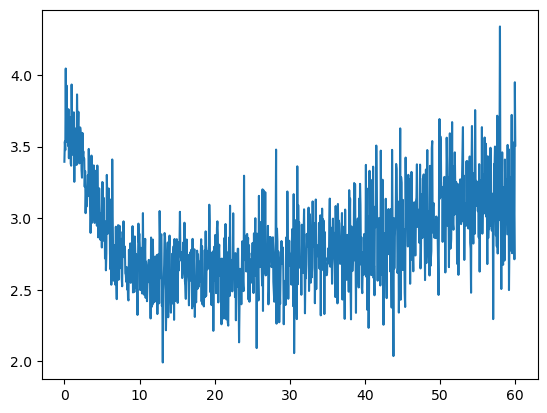

In [305]:
import matplotlib.pyplot as plt

plt.plot(learning_rates, losses)

From this chart, we can notice two things. Firstly, the blue line appears to be fluxuating a lot. This makes sense, as using mini-batches as small as we used means that often the correct label in one batch will be incorrect in the next batch, causing a higher loss. The second thing we can see from this chart is that it actually appears that our previous learning rate of 0.1 wasn't too high at all. What we were seeing before must have been due to all the fluxuations between batches. Here we can see that the loss on a whole doesn't seem to rise until the learning rate reaches above 14. Now that we've seen the results of different learning rates, let's try training our model with a learning rate of 14.

<!-- In fact, it seems like the ideal learning rate may be 

We can see that the loss fluctuates a lot. Explains why we saw it jump around earlier.

Since we are using very small mini batches, the loss fluxuates a lot, as it's common that one batch would contain labels that are different from the previous one. This is why the blue line in the graph is so thick -- it jumps up and down a lot between batches. However, looking at this graph, it doesn't seem like any of these rates are too high. A high learning rate would cause the loss to rise back up, but although it jumps around between batches, the loss on a whole never noticeably seems to climb back up. This may be a result of the simplicity of our model. We didn't add anything to make the model non-linear, so there is less to cause the loss to bounce around. -->

In [308]:
# Reset the network once again to start fresh.
gen = torch.Generator().manual_seed(42)
W = torch.randn((27, 27), generator = gen, requires_grad=True)

# Update the model again, this time testing a different learning rate each time.
for update in range(10000):
    
    # Train on batches for quicker updates to weights.
    batch_indices = torch.randint(0, train_X_enc.size(0), (32,), generator=gen)
    batch_X = train_X_enc[batch_indices]
    batch_y = train_y[batch_indices]
    
    # Try updating with the new learning rate.
    loss = train(batch_X, batch_y, 14)    
    
    # Check model progress every 1000 updates.
    if update % 1000 == 0:
        print(f"Loss = {loss}")

Loss = 3.3938217163085938
Loss = 2.542206287384033
Loss = 2.4245188236236572
Loss = 2.5128555297851562
Loss = 2.419407606124878
Loss = 2.758533239364624
Loss = 2.581160545349121
Loss = 2.9077208042144775
Loss = 2.2751142978668213
Loss = 2.3665781021118164


As you can see, this new learning rate got us a better loss from before. But a good loss on the training data doesn't necessarily mean that our model is good in general. To make sure it learned patterns that can be used for predicting data it hasn't seen yet, we'll need to test it on the dev set. 
<!-- 
If the loss for that  

(rather than overtraining)

But now we'll need to check the loss for the validation set to make sure that our model is trained enough to work on data never seen before. -->

In [314]:
# Do a forward pass on the dev set to find its loss.
logits = dev_X_enc @ W
logits -= torch.max(logits, dim=1, keepdim=True)[0]
probs = logits.exp() / torch.sum(logits.exp(), dim=1, keepdims=True)
label_probs = probs[torch.arange(dev_y.numel()), dev_y]
loss = -label_probs.log().mean()

print(f"The loss on the dev set is {loss}")

The loss on the dev set is 2.5827548503875732


That seems fairly close to our test set's loss, so it seems safe to say that our model has actually learned patterns it can use on new data. 

TODO: Maybe mention learning rate decay? Then use model to generate names.
___________

As you can see, minibatches make training significantly faster. However, if you look carefully, you'll notice that those loss values weren't strictly decreasing. Occasionally, the model temporarily got worse before improving. That might mean that the learning rate we used is too large, making the weights adjust by too much each iteration. A lower learning rate might be better, but if we pick one that is too low, the model will hardly adjust each iteration and can end up training very slowly.

To find a perfect learning rate, we can try out many learning rates at different ranges. Good learning rates can range between $10^{-5}$ to $10^0$, so we'll want to explore the rates within each of those ranges equally. For that, we can test several logarithmically spaced values between those ranges.

<!-- test each of these rates  -->


<!-- That was much quicker. However, notice how the loss occasionally rose instead of strictly decreasing?

it looks like our loss occasionally rose -->


<!-- Model loss occasionally rose before falling back down. (Test on dev set + then discuss finding optimal learning rate?) -->

In [180]:
# Reset the W matrix before testing learning rates so it starts untrained.
gen = torch.Generator().manual_seed(42)
# Remember, each column in the weights matrix represents a neuron in the layer.
W = torch.randn((27, 27), generator = gen, requires_grad=True)

# # Get 1000 values logarithmically spaced between 10**-5 and 10**0.
learning_rates = torch.logspace(-5, 0, 10000)

# Keep track of how loss changes as learning rate changes.
losses = []

# Update the model again, this time testing a different learning rate each time.
for update in range(10000):
    
    # Train on batches for quicker updates to weights.
    batch_indices = torch.randint(0, train_X_enc.size(0), (32,), generator=gen)
    batch_X = train_X_enc[batch_indices]
    batch_y = train_y[batch_indices]
    
    # Try updating with the new learning rate.
    loss = train(batch_X, batch_y, learning_rates[update])
    # losses.append(loss.log10().item())
    losses.append(loss.item())

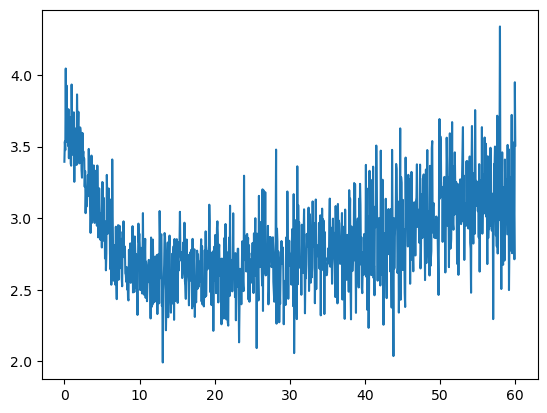

In [193]:
import matplotlib.pyplot as plt

plt.plot(learning_rates, losses)

In [148]:
# Go through the full training data several times to keep making improvements.
for _ in range(10):
    ### Forward pass. ###

    # Select row for each letter in train_X.
    logits = train_X_enc @ W
    # Offset to prevent overflow. Max function returns (values, indices), so only select values.
    logits -= torch.max(logits, dim=1, keepdim=True)[0]
    # Use softmax function to turn logits into percents.
    pos = logits.exp()
    probs = pos / pos.sum(dim=1, keepdims=True)
    # For each row of probs, check model's prediction for label.
    predictions = probs[torch.arange(train_X_enc.size(0)), train_y]
    # Use NLL loss.
    loss = -predictions.log().mean()
    # Track loss to see it improve with each iteration.
    print(f"loss = {loss.item()}")

    ### Backward pass. ###

    # Reset gradients.
    W.grad = None
    # Backpropagate through full network.
    loss.backward()
    # Adjust weights by learning rate to improve loss.
    W.data += -0.1 * W.grad

loss = 3.696241617202759
loss = 3.695483684539795
loss = 3.694725513458252
loss = 3.6939687728881836
loss = 3.6932129859924316
loss = 3.6924571990966797
loss = 3.6917028427124023
loss = 3.6909494400024414
loss = 3.6901957988739014
loss = 3.6894431114196777


As we keep training, the loss will decrease until the model reaches a point where it can't improve further. 

<!-- So far, we've only run 10 iterations (nudging the weights just 10 times) which is far from enough to fully train a model. However, updating the weights using the entire training set for every adjustment can be slow, especially as the dataset grows. Each iteration would require processing all examples, making training increasingly time-consuming. To speed things up, we can train on minibatches, which are small subsets of the data. This allows us to make more frequent weight updates while still moving each weight in the right direction. -->

<!-- As we keep training the model, the loss will continue to decrease until the model reaches a point where it can't improve anymore. So far we ran it for 10 iterations, which means that it only nudged the weights 10 times. That is not nearly enough to fully train a model. But making the model go through every letter of the training data each time we want to slightly adjust the weights can be very time consuming, and the larger the dataset, the slower each iteration takes. Luckily, we can speed up the training process substantially using minibatches. -->

### Training with Minibatches

So far, we've only run 10 iterations (nudging the weights just 10 times) which is far from enough to fully train a model. However, updating the weights using the entire training set for every adjustment can be slow, especially as the dataset grows. Each iteration would require processing all examples, making training increasingly time-consuming. To speed things up, we can train on minibatches, which are small subsets of the data. This allows us to make more frequent weight updates while still moving each weight in the right direction. Let's try that now. (I'll rewrite the code in different words this time. Use whichever helps make the concepts more clear to you.)

<!-- Let's try training using minibatches this time. We can do this by randomly selecting some examples from our training data each iteration and only training on that selection. We'll put the code in a function now so we can use it many times and test how well it performs.  -->

<!-- We'll also use `lr` as a parameter to the function so we can  -->

<!-- To train with minibatches, we randomly select some examples from our training data each iteration and only train on that selection for the iteration. -->


<!-- We can do this by making a list of length `minibatch_size` where each element is a random index in X. Then we can use that to index on train_X_enc and train on that. -->



<!-- Since we 

- Make list of length minibatch_size where each element is a random index in X. Use that to index X and train on that. -->

In [149]:
def train():
    for _ in range(1000):
        # Pick 32 random indices of train_X to go in our batch.
        batch_indices = torch.randint(0, train_X_enc.size(0), (32,), generator=gen)
        # Select each of the random 32 rows (each row indicating a single one-hot encoded letter).
        batch = train_X_enc[batch_indices]
        # Select their matching labels.
        batch_labels = train_y[batch_indices]
        
        #### Forward Pass ####
        
        logits = batch @ W
        # Offset each row by max number to prevent overflow.
        logits -= torch.max(logits, dim=1, keepdim=True)[0]
        # Softmax to get probabilities of following letters.
        probs = logits.exp() / torch.sum(logits.exp(), dim=1, keepdims=True)
        # Check probability assigned to labels to see how well model performed.
        label_probs = probs[torch.arange(32), batch_labels]
        # Get loss using Negative Log Likelihood and normalize result.
        loss = -label_probs.log().mean()
        
        #### Backwards Pass ####
        
        # Always reset the gradient before backpropagation!
        W.grad = None
        # Backpropagate through the network.
        loss.backward()
        # Use gradient descent to nudge weights by the learning rate.
        W.data -= 0.1 * W.grad
        
    # Return loss found before the final adjustment.
    return loss.item()

In [150]:
print("Checking model progress every 1000 training iterations.")

# Go through 1000 iterations 10 times to see impovements.
for _ in range(10):
    print(f"Loss = {train()}")

Checking model progress every 1000 training iterations.
Loss = 3.08286452293396
Loss = 2.9375686645507812
Loss = 2.663137197494507
Loss = 2.4567668437957764
Loss = 2.806462526321411
Loss = 2.6709558963775635
Loss = 2.5657105445861816
Loss = 2.7251834869384766
Loss = 2.481252670288086
Loss = 2.3794548511505127


TODO: Continue here

Model loss occasionally rose before falling back down. (Test on dev set + then discuss finding optimal learning rate?)

As we keep training the model, the loss will continue to decrease until the model reaches a point where it can't improve anymore. However, since training on so much data is slow, we'll stop improving the model for now and start using it to generate new, never-before-seen names!

<a id="generate"></a>
## Generating Names

Now we're ready to use this newly trained model to generate names of its own. Remember how earlier we taught our model that each name starts after a "." character? This will finally come in handy here. To start generating a name, we'll feel the network the "." character as input. Our newly trained model should have learned which letters are most likely to follow ".", and thus should know what letters tend to start names. If we input "." into the model now, we can see this for ourselves.

In [ ]:
import matplotlib.pyplot as plt    # For displaying results.


# Encode "." to use it as input for our model.
encoded = F.one_hot(torch.tensor(stoi["."]), num_classes=27).float()

# Input "." into our model.
logits = encoded @ W
probs = logits.exp() / sum(logits.exp())    # Softmax on one line.


# Display model's output.
plt.bar(stoi.keys(), probs.tolist())
plt.title("Distribution of First Letters in Names")
plt.show()

It seems our model learned from the data that "a" is a very likely first letter, followed by "k". We can now use multinomial sampling to select a letter based on the weights in this distribution. This gives the model some randomness while still taking the probability of each letter into account. Let's try it now.

In [ ]:
# Resetting generator so cell always gives same letters instead of generating the next letters.
gen = torch.Generator().manual_seed(42)

# Sample a first letter for a name 5 times.
letter_indices = torch.multinomial(probs, num_samples=5, replacement=True, generator=gen).tolist()

# Turn the indices of those letters into the actual letters.
for index in letter_indices:
    print(itos[index])

Those results perfectly demonstrate how the sampling works. Since "a" is so likely to follow ".", it chose "a" four times, but we can see that it has leeway to pick other letters as well. Making the model generate a full name is the same process as making it generate the first letter. Once it generates the first letter, we send that letter through the model and select from *it's* outputs to produce a next letter, and on and on until the model finally selects a ".", indicating the end of a name. 

Now we're ready to generate some names!

In [ ]:
gen = torch.Generator().manual_seed(42)


def generate_name():
    name = []
    
    # Start with 0 (".") to find first letter of name.
    letter_idx = 0

    while True:
        # Encode the letter to use in model.
        encoded = F.one_hot(torch.tensor(letter_idx), num_classes=27).float()

        # Send letter through model.
        logits = encoded @ W
        probs = logits.exp() / sum(logits.exp())

        # Sample next letter of the name.
        letter_idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=gen).item()

        # If the letter selected is ".", we've finished the name.
        if letter_idx == 0:
            return "".join(name).capitalize()
        
        # Otherwise, add the new letter to the name.
        name.append(itos[letter_idx])
        

In [ ]:
# Generate 10 names.
for _ in range(10):
    print(generate_name())

Most of these generated names are pretty bad, but that is to be expected from such a simple model that relies only on bigrams. Interestingly, one name generated was Chen, which happens to be the name of a close friend of mine. 

A satisfying end to a fun, simple neural network exploration.

<a id="next"></a>
## Next Steps

This basic name generator was only the beginning. Next time, we'll walk through hidden layers, embeddings, and more. Stay tuned!